In [3]:
%load_ext autoreload
%autoreload 2

In [32]:
import numpy as np
import pandana as pdna
import geopandas as gpd
import pandas as pd
import math
import networkx as nx
import sys
# adding functions 
sys.path.insert(0, 'C:\\Users\\z3258367\\OneDrive - UNSW\\#PhD\\Walkability\\Other Cities\\Open-Walk-Index')
from walkability_functions import *

Choose a projected CRS to be used for all distance calculations.

In [5]:
proj_crs = "EPSG:7856"

## Import Data

Data sources:
1. Shape of Greater Sydney - used to clip points
2. Points of interest from OSM - using Geofabriks shapefiles as the source
3. Transport for NSW public transport stops
4. Spatial Services NSW for additional POIs
5. Employment data - processed from ABS originally

In [6]:
folder = "C:\\Users\\z3258367\\OneDrive - UNSW\\#PhD\\"
Greater_Sydney = gpd.read_file((folder + 
    "Data\\greater_sydney_shape\\Greater_Sydney_Dissolve.shp")
    ).to_crs(proj_crs)

In [7]:
osm_poi_points = gpd.read_file(''.join((folder, 
    "Walkability\\Mavoa\\Pandana inputs\\Greater_Sydney_OSM_POIs_sp.shp")))
osm_poi_areas = gpd.read_file(folder + 
    "Walkability\\Mavoa\\Pandana inputs\\Greater_Sydney_OSM_POIs_a_sp.gpkg")
osm_transport_points = gpd.read_file(folder +
    "Walkability\\Mavoa\\Pandana inputs\\Greater_Sydney_OSM_transport_sp.shp")
osm_transport_areas =  gpd.read_file(folder +
    "Data\\OSM-australia-latest-free\\gis_osm_transport_a_free_1.shp")
osm_pow_points = gpd.read_file(folder + 
    "Data\\OSM-australia-latest-free\\gis_osm_pofw_free_1.shp")
osm_pow_areas = gpd.read_file(folder + 
    "Data\\OSM-australia-latest-free\\gis_osm_pofw_a_free_1.shp")
osm_natural = gpd.read_file(folder + 
    "Data\\OSM-australia-latest-free\\gis_osm_natural_a_free_1.shp")

# the OSM POIs includes domestic swimming pools in some suburbs. This line removes swimming pools less than 100m2.
# Same for domestic tennis courts appearing as 'pitches'. Removed pitches below 450m2.
osm_poi_areas = osm_poi_areas[~((osm_poi_areas['fclass']=='swimming_pool') & (osm_poi_areas.to_crs(proj_crs).area < 100))]
osm_poi_areas = osm_poi_areas[~((osm_poi_areas['fclass']=='pitch') & (osm_poi_areas.to_crs(proj_crs).area < 450))]

In [8]:
# import SS NSW data
SS_NSW = gpd.read_file((folder + 
                        "Data\\NSW Spatial Services\\NSW_Features_of_Interest_Category.gdb"),layer='BuildingComplexPoint')
SS_NSW.to_crs(Greater_Sydney.crs, inplace = True)
SS_NSW['fclass'] = (SS_NSW['classsubtype'].astype(str) + "-" 
                    + SS_NSW['buildingcomplextype'].astype(str))

# add general cultural points
SS_NSW_gc = gpd.read_file((folder + 
                           "Data\\NSW Spatial Services\\NSW_Features_of_Interest_Category.gdb"),layer='GeneralCulturalPoint')
SS_NSW_gc.to_crs(Greater_Sydney.crs, inplace = True)
SS_NSW_gc['fclass'] = (SS_NSW_gc['classsubtype'].astype(str) + "-" 
                       + SS_NSW_gc['generalculturaltype'].astype(str) + "-gc")

SS_NSW = pd.concat([SS_NSW, SS_NSW_gc]).to_crs(proj_crs)

In [9]:
SS_names = {'4-10': 'shopping centre', '2-18': 'post office', '2-16': 'place of worship',
 '3-3': 'health centre', '3-5': 'health centre', '3-6': 'health centre',
 '1-1': 'school', '1-2': 'school', '1-3': 'school', '1-5': 'school', '1-6': 'school',
 '1-8': 'school', '1-4': 'university', '1-7': 'childcare',
 '2-2': 'art gallery', '2-11': 'library', '2-14': 'museum',
 '6-12': 'sports centre', '6-18': 'zoo', '1-6-gc': 'outdoor theater',
 '6-15': 'swimming pool', '9-2-gc': 'swimming pool',
 '6-17': 'tourist attraction', '1-2-gc': 'golf course', '1-5-gc': 'lookout',
 '1-7-gc': 'park', '1-8-gc': 'picnic area', '1-12-gc': 'sports field', '1-13-gc': 'sports field'}

SS_NSW.replace({'fclass': SS_names},inplace=True)

In [82]:
employment_centrs = gpd.read_file((folder + 
                        "Walkability\\Other Cities\\Colouring data & results\\Sydney Data\\Data\\NSW_Employment_meshblocks.gpkg"),
                                  layer='centroids').to_crs(proj_crs)
    #"Data\\Colouring\\Centroids employment MBs.gpkg")

Convert polygonal datasets to points and any multipart datasets to single part.

In [11]:
osm_pois_2 = single_points(osm_poi_areas)
osm_transport_2 = single_points(osm_transport_areas)
osm_pow_2 = single_points(osm_pow_areas)
osm_natural_2 = single_points(osm_natural)

osm_df = pd.concat([osm_poi_points, osm_pois_2, osm_transport_points, 
                    osm_transport_2, osm_pow_points, osm_pow_2, osm_natural_2]).to_crs(proj_crs)

osm_df = gpd.clip(osm_df, Greater_Sydney)

### Residential population

In [12]:
meshblocks = pd.read_csv(''.join(folder + "Data\\ABS Data\\2016 census mesh block counts.csv"))
mb_shapes = gpd.read_file(''.join(folder + "Data\\ABS Data\\2016_NSW_MBs\\MB_2016_NSW.shp"))

In [13]:
mb_shapes['MB_CODE16'] = mb_shapes['MB_CODE16'].astype('int64')

pop_mbs = mb_shapes.join(meshblocks.set_index('MB_CODE_2016'), on='MB_CODE16', how='inner', rsuffix='_2')
pop_mbs['geometry'] = pop_mbs['geometry'].to_crs(proj_crs).centroid

pop_pois = pop_mbs[(pop_mbs['Person'] > 0) & ~(pop_mbs['geometry'].isnull())][
    ['MB_CODE16', 'MB_CATEGORY_NAME_2016', 'AREA_ALBERS_SQKM', 'Person','geometry']]
pop_pois['fclass'] = 'residential'

 10,000 for population? Micropolitan size?
 For jobs: Colin Clark reports that cities need 100,000-200,000 in order to provide an adequate range of commercial services. 200-500k to support broadly based manufacturing activity.

### Categorise and weight POIs

Choose walk index weightings, and output the sums of each category and the total to check. The walk index will be out of 100 regardless of this sum, but it is important to note that eg. shopping is only '10% of the walk index' if shopping is 10 out of 100.

In [14]:
poi_weights = {
    "employment": 29,
    "education": 13,
    "daily needs": 13.8,
    "other goods": 5.8,
    "services": 1.5,
    "medical": 3.6,
    "errands": 1.5,
    "visiting": 9.4,
    "cultural": 1.5,
    "events": 1.5,
    "sports": 4.4,
    "restaurants": 3.6,
    "day trip": 0.7,
    "walk/jog/ride": 5.1,
    "walk dog": 2.9,
    "religious": 1.5,
    "accompany children": 1.5,
}

poi_numbers = {
    "employment": 100,
    "education": 5,
    "daily needs": 5,
    "other goods": 5,
    "services": 5,
    "medical": 5,
    "errands": 5,
    "visiting": 5,
    "cultural": 5,
    "events": 5,
    "sports": 5,
    "restaurants": 5,
    "day trip": 5,
    "walk/jog/ride": 5,
    "walk dog": 5,
    "religious": 5,
    "accompany children": 5,
}


In [15]:
#category_sums = {k: sum(v) for k, v in poi_weights.items()}
#print(category_sums)
total = sum(poi_weights.values())
print("total: ", total)

total:  100.3


The purpose of this section now is just to align the different sources of information so that their tags are in the same column, eg 'category'. 

In [16]:
SS_categories = {'other goods':["shopping centre"], 
                 'errands':["post office",], 
                 'medical':["health centre"],
                 'education':["school", "university", "childcare"],
                 'visiting' : ["picnic area"],
                 'religious':["place of worship", ],
                 'cultural':["art gallery", "library", "museum", "outdoor theater",],
                 'sports':["sports centre", "sports field", "swimming pool",
                         "golf course", ],
                 'day trip' : ["tourist attraction", "zoo", "lookout",],
                 'walk/jog/ride' : ['park',],}

SS_categorised = categorise_pois(SS_NSW, SS_categories, 
                                 old_column='fclass')

osm_categories = {'daily needs' : ['supermarket', 'greengrocer','butcher','convenience',
                                   'kiosk', 'beverages', 'alcohol', 'bakery', ],
                  'other goods' : ['mall', 'bicycle_shop', 'clothes', 'department_store', 
                                   'doityourself', 'beauty_shop', 'outdoor_shop', 
                                   'stationery', 'bookshop', 'gift_shop', 'newsagent', 
                                   'car_dealership', 'furniture_shop', 'sports_shop',
                                   'garden_centre', 'computer_shop', 'shoe_shop', 'florist', 
                                   'video_shop', 'toy_shop', 'mobile_phone_shop', 'jeweller'],
                  'services': ['hairdresser', 'optician', 'travel_agent','laundry', 'veterinary', ],                 
                  'medical': ['chemist', 'pharmacy','doctors', 'dentist','hospital',],                  
                  'errands' : ['post_box', 'post_office', 'bank', 'atm','courthouse' ], 
                  'education' : ['college', 'school', 'kindergarten', 'university'],
                  'visiting' : ['picnic_site', 'nursing_home'],
                  'cultural' : [ 'arts_centre', 'theatre', 'artwork','library',
                                'archaeological', 'cinema', 'museum', 'ruins',],
                  'events' : ['stadium',],
                  'sports' : ['ice_rink','pitch', 'swimming_pool', 'sports_centre', 
                             'golf_course', 'track',],
                  'further education' : ['community_centre', 'library',],
                  'restaurants' : ['restaurant', 'pub', 'cafe', 'fast_food', 'bar',  
                                   'food_court', 'nightclub', 'biergarten',],
                  'day trip' : ['attraction', 'zoo', 'castle', 
                                'theme_park',],
                  'walk/jog/ride' : ['park', 'viewpoint', 'beach'],
                  'walk dog' : ['dog_park', 'park',],
                  'religous' : ['graveyard', 'christian_anglican', 'muslim',
                                'christian', 'christian_catholic', 'christian_protestant',
                                'christian_lutheran', 'hindu', 'christian_evangelical',
                                'christian_methodist', 'buddhist', 'sikh', 'christian_orthodox', 'jewish',
                                'muslim_sunni', 'taoist', 'muslim_shia'],
                  'hobby' : [],
                  'accompany children' : ['playground', 'library',],
                    }

osm_categorised = categorise_pois(osm_df, osm_categories, 
                                  old_column='fclass')

Tags present in the dataset but not categorised:
['4-6' '2-24' '5-9' '2-0' '5-10' '2-8' '2-12' '3-0' '2-4' '6-3' '2-17'
 '2-21' '2-20' '2-9' '5-8' '4-7' '4-4' '4-8' '2-23' '1-0' '3-1' '2-19'
 '2-5' '4-0' '2-6' '2-7' '2-1' '5-1' '4-1' '2-10' '2-15' '5-5' '5-11'
 '5-2' '4-2' '4-3' '5-3' '4-9' '5-6' '3-4' '5-7' '6-0' '5-0' '6-2'
 '4-11-gc' '12-0-gc' '8-0-gc' '4-12-gc' '1-4-gc' '4-7-gc' '7-0-gc'
 '4-6-gc' '4-2-gc' '8-2-gc' '6-5-gc' '1-14-gc' '12-1-gc' '1-1-gc' '7-2-gc'
 '7-1-gc' '1-11-gc' '4-9-gc' '4-3-gc' '5-0-gc' '5-1-gc' '4-0-gc' '4-4-gc'
 '6-2-gc' '2-0-gc' '4-8-gc' '2-1-gc' '8-1-gc' '1-3-gc' '3-1-gc' '6-4-gc'
 '7-3-gc' '4-5-gc' '2-2-gc' '6-7-gc' '7-4-gc' '6-8-gc' '6-6-gc' '6-3-gc'
 '2-3-gc' '1-10-gc' '4-13-gc' '1-0-gc' '7-5-gc' '9-0-gc' '9-1-gc' '6-1-gc'
 '3-0-gc' '6-0-gc']
Tags present in the dataset but not categorised:
['toilet' 'drinking_water' 'camp_site' 'shelter' 'waste_basket'
 'telephone' 'bench' 'railway_station' 'bus_stop' 'fire_station'
 'tourist_info' 'police' 'motel' 'mem

Categorise POI data - change classes depending on your analysis and your data sources.

In [17]:
poi_categories = {'employment':[],
                  'daily needs' : ['supermarket', 'greengrocer','butcher','convenience',
                                   'kiosk', 'beverages', 'alcohol', 'bakery', ],
                  'other goods' : ["shopping centre", 'mall', 'bicycle_shop', 'clothes', 'department_store', 
                                   'doityourself', 'beauty_shop', 'outdoor_shop', 
                                   'stationery', 'bookshop', 'gift_shop', 'newsagent', 
                                   'car_dealership', 'furniture_shop', 'sports_shop',
                                   'garden_centre', 'computer_shop', 'shoe_shop', 'florist', 
                                   'video_shop', 'toy_shop', 'mobile_phone_shop', 'jeweller'],
                  'services': ['hairdresser', 'optician', 'travel_agent','laundry', 'veterinary', ],                 
                  'medical': ["health centre",'chemist', 'pharmacy','doctors', 'dentist','hospital',],                  
                  'errands' : ["post office",'post_box', 'post_office', 'bank', 'atm','courthouse' ], 
                  'education' : ["childcare", 'college', 'school', 'kindergarten', 'university'],
                  'visiting' : ['residential'],
                  'cultural' : ["art gallery", "outdoor theater", 'arts_centre', 'theatre', 'artwork',
                                'library','archaeological', 'cinema', 'museum', 'ruins',],
                  'events' : ['stadium',],
                  'sports' : ["sports centre", "sports field", "swimming pool", "golf course", 
                              'ice_rink','pitch', 'swimming_pool', 'sports_centre', 
                              'golf_course', 'track',],
                  'further education' : ['community_centre', 'library',],
                  'restaurants' : ['restaurant', 'pub', 'cafe', 'fast_food', 'bar',  
                                   'food_court', 'nightclub', 'biergarten',],
                  'day trip' : ["tourist attraction", "lookout", 'attraction', 'zoo', 'castle', 
                                'theme_park',],
                  'walk/jog/ride' : ['park', 'viewpoint', 'beach'],
                  'walk dog' : ['dog_park', 'park',],
                  'religious' : ["place of worship", 'graveyard', 'christian_anglican', 'muslim',
                                'christian', 'christian_catholic', 'christian_protestant',
                                'christian_lutheran', 'hindu', 'christian_evangelical',
                                'christian_methodist', 'buddhist', 'sikh', 'christian_orthodox', 'jewish',
                                'muslim_sunni', 'taoist', 'muslim_shia'],
                  'hobby' : [],
                  'accompany children' : ['playground', 'library',],
                    }

osm_categorised = categorise_pois(osm_df, poi_categories, 
                                  old_column='fclass')
SS_categorised = categorise_pois(SS_NSW, poi_categories, 
                                 old_column='fclass')
pop_categorised = categorise_pois(pop_pois, poi_categories, 
                                 old_column='fclass')

Tags present in the dataset but not categorised:
['toilet' 'drinking_water' 'camp_site' 'shelter' 'picnic_site'
 'waste_basket' 'telephone' 'bench' 'railway_station' 'bus_stop'
 'fire_station' 'tourist_info' 'police' 'motel' 'memorial' 'caravan_site'
 'water_tower' 'bus_station' 'town_hall' 'wastewater_plant' 'comms_tower'
 'tower' 'nursing_home' 'guesthouse' 'cliff' 'observation_tower' 'prison'
 'vending_any' 'monument' 'recycling_paper' 'vending_parking' 'fountain'
 'car_wash' 'hotel' 'camera_surveillance' 'recycling' 'embassy' 'taxi'
 'car_rental' 'public_building' 'water_works' 'tram_stop' 'hostel'
 'recycling_clothes' 'vending_machine' 'recycling_glass' 'bicycle_rental'
 'car_sharing' 'fort' 'lighthouse' 'hunting_stand' 'tree' 'ferry_terminal'
 'chalet' 'railway_halt' 'water_well' 'windmill' 'battlefield'
 'water_mill']
Tags present in the dataset but not categorised:
['4-6' '2-24' '5-9' '2-0' '5-10' '2-8' '2-12' '3-0' '2-4' '6-3' '2-17'
 '2-21' '2-20' '2-9' '5-8' '4-7' '4-4' '4-8

Need to remove potential overlap between different data sources (and inside some data sources). For this dataset it's around 30% because there is overlap of public transport stops between OSM and TfNSW, and overlap of things like post offices between OSM and SSNSW. Then take this combined POI set and clip it to the study area: should be the same area as is covered by the network. This is important otherwise points outside the network may be erroneously linked to the network.

In [18]:
pois = remove_duplicate_pois([osm_categorised, SS_categorised, pop_categorised], buffer=10)

pois = gpd.clip(pois, Greater_Sydney)

Removed 1.91% duplicate points from dataframes


In [19]:
no_opps = pois.groupby(['category']).size()
no_opps['residential']

47290

### Import network

In this case the network is already in the same projected CRS as everything else but I have left in the transformation to be clear.

In [20]:
# reading directly with geopandas.read_file crashes on my computer so I read into pandas then convert to gdf instead
edges_df = pd.read_csv(folder + "Walkability//Other Cities//Colouring data & results//Sydney data//Data//colouring_edges_150322.csv")
nodes_df = pd.read_csv(folder + "Walkability//Other Cities//Colouring data & results//Sydney data//Data//colouring_nodes_150322.csv")
edges = gpd.GeoDataFrame(edges_df, 
                         geometry=gpd.GeoSeries.from_wkt(edges_df['geometry'])).set_crs(proj_crs)
nodes = gpd.GeoDataFrame(nodes_df, 
                         geometry=gpd.GeoSeries.from_wkt(nodes_df['geometry'])).set_crs(proj_crs)
edges = edges.to_crs(proj_crs)
nodes = nodes.to_crs(proj_crs)

C:\Users\z3258367\Anaconda3\envs\ox\lib\site-packages\IPython\core\interactiveshell.py:3331: DtypeWarning: Columns (2,4,5,7,9,13,14,19,21) have mixed types.Specify dtype option on import or set low_memory=False.
  exec(code_obj, self.user_global_ns, self.user_ns)
C:\Users\z3258367\Anaconda3\envs\ox\lib\site-packages\IPython\core\interactiveshell.py:3331: DtypeWarning: Columns (6,11,12) have mixed types.Specify dtype option on import or set low_memory=False.
  exec(code_obj, self.user_global_ns, self.user_ns)


<class 'str'>
<class 'str'>


Pandana expects edges to have a two item index based on the same IDs as the node index.

In [21]:
nodes.set_index('connect_id',inplace=True)

edges['from_idx'] = edges['from']
edges['to_idx'] = edges['to']
edges= edges.set_index(['from_idx', 'to_idx'])
edges.index.names= ['from_idx','to_idx']

## Pandana network creation.

In [22]:
distance_network = pdna.Network(nodes['x'], nodes['y'],
                                   edges['from'], edges['to'], 
                                   edges[['length']])

maximum_dist = 2400

Get distributions of number of reachable destinations in each category across the network, to check whether the max destinations we use is reasonable.

### Pandana network querying. 
The 'employment' category is empty because we didn't add the employment points to the POI dataset.

In [23]:
results_4 = walk_index(distance_network, pois, poi_categories, poi_weights, poi_numbers, distance=maximum_dist)  

Category employment is empty
Finished category: education
Finished category: daily needs
Finished category: other goods
Finished category: services
Finished category: medical
Finished category: errands
Finished category: visiting
Finished category: cultural
Finished category: events
Finished category: sports
Finished category: restaurants
Finished category: day trip
Finished category: walk/jog/ride
Finished category: walk dog
Finished category: religious
Finished category: accompany children


In [31]:
for cat in list(poi_numbers.keys()):
    print(cat, len(pois[pois['category'].isin(poi_categories[cat])]))

employment 0
education 3627
daily needs 2003
other goods 2331
services 620
medical 1007
errands 2019
visiting 47290
cultural 1001
events 50
sports 8713
restaurants 5378
day trip 618
walk/jog/ride 12303
walk dog 11353
religious 2898
accompany children 2930


In [36]:
counts = primal_2(distance_network, pois, 500, list(poi_categories.keys()), poi_categories)

Category employment is empty
Finished category: daily needs
count    3.847528e+06
mean     4.066712e-01
std      1.627336e+00
min      0.000000e+00
25%      0.000000e+00
50%      0.000000e+00
75%      0.000000e+00
max      4.100000e+01
dtype: float64
Finished category: other goods
count    3.847528e+06
mean     4.342352e-01
std      2.515849e+00
min      0.000000e+00
25%      0.000000e+00
50%      0.000000e+00
75%      0.000000e+00
max      9.900000e+01
dtype: float64
Finished category: services
count    3.847528e+06
mean     1.477206e-01
std      8.668790e-01
min      0.000000e+00
25%      0.000000e+00
50%      0.000000e+00
75%      0.000000e+00
max      2.400000e+01
dtype: float64
Finished category: medical
count    3.847528e+06
mean     2.052170e-01
std      8.872054e-01
min      0.000000e+00
25%      0.000000e+00
50%      0.000000e+00
75%      0.000000e+00
max      2.200000e+01
dtype: float64
Finished category: errands
count    3.847528e+06
mean     4.187216e-01
std      1.586876e+

In [84]:
count_residential = primal(distance_network, pois, 1200, 200, ['residential'], poi_categories)

Finished category: sports


In [52]:
counts[nodes['connect_type'] == 'poi'].describe(percentiles=[.25, .5,.6,.7, .75,.8,.9]).applymap(lambda x: format(x, 'g'))

,x,y,employment,daily needs,other goods,services,medical,errands,education,visiting,...,events,sports,further education,restaurants,day trip,walk/jog/ride,walk dog,religious,hobby,accompany children
count,1.34282e+06,1.34282e+06,1.34282e+06,1.34282e+06,1.34282e+06,1.34282e+06,1.34282e+06,1.34282e+06,1.34282e+06,1.34282e+06,...,1.34282e+06,1.34282e+06,1.34282e+06,1.34282e+06,1.34282e+06,1.34282e+06,1.34282e+06,1.34282e+06,1.34282e+06,1.34282e+06
mean,316966,6.25854e+06,0,0.342586,0.347359,0.126351,0.176499,0.361841,0.439079,7.28156,...,0.00247985,0.737389,0.0696928,0.935288,0.025048,1.47904,1.45964,0.467709,0,0.443179
std,20881.7,22014.2,0,1.41086,2.25274,0.761184,0.790276,1.38175,1.01106,7.93819,...,0.059034,1.86715,0.32981,5.13216,0.443957,1.75758,1.72907,1.12989,0,0.755916
min,221549,6.19862e+06,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0
25%,303273,6.24436e+06,0,0,0,0,0,0,0,3,...,0,0,0,0,0,0,0,0,0,0
50%,317636,6.25688e+06,0,0,0,0,0,0,0,5,...,0,0,0,0,0,1,1,0,0,0
60%,323030,6.26081e+06,0,0,0,0,0,0,0,6,...,0,0,0,0,0,1,1,0,0,0
70%,327136,6.26446e+06,0,0,0,0,0,0,0,8,...,0,0,0,0,0,2,2,0,0,1
75%,329617,6.26626e+06,0,0,0,0,0,0,0,9,...,0,1,0,0,0,2,2,0,0,1
80%,333988,6.26887e+06,0,0,0,0,0,0,1,10,...,0,1,0,0,0,3,3,1,0,1


<AxesSubplot:>

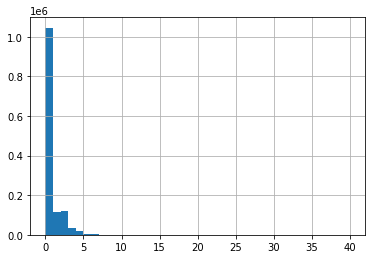

In [57]:
counts[nodes['connect_type'] == 'poi'].education.hist(bins=40)

In [58]:
# These are the usual ipython objects, including this one you are creating
ipython_vars = ['In', 'Out', 'exit', 'quit', 'get_ipython', 'ipython_vars']
# Get a sorted list of the objects and their sizes
sorted([(x, sys.getsizeof(globals().get(x))) for x in dir() if not x.startswith('_') and x not in sys.modules and x not in ipython_vars], key=lambda x: x[1], reverse=True)

[('results_4', 3108802640),
 ('edges_df', 2783752843),
 ('edges', 2678983512),
 ('SS_NSW', 1311962272),
 ('SS_NSW_gc', 1196735579),
 ('nodes_df', 1145978627),
 ('nodes', 792861861),
 ('counts', 677164944),
 ('pop_mbs', 117412253),
 ('pois', 114374531),
 ('mb_shapes', 105589359),
 ('SS_categorised', 46167579),
 ('meshblocks', 38526824),
 ('pop_categorised', 20555652),
 ('pop_pois', 14833588),
 ('employment_centrs', 13448454),
 ('osm_df', 12833052),
 ('osm_categorised', 10313941),
 ('osm_poi_points', 4832102),
 ('osm_pois_2', 4593675),
 ('osm_poi_areas', 4534091),
 ('osm_transport_points', 1660421),
 ('osm_natural_2', 1034700),
 ('osm_pow_2', 1004213),
 ('osm_natural', 840096),
 ('osm_pow_areas', 828235),
 ('osm_pow_points', 568319),
 ('osm_transport_2', 112408),
 ('osm_transport_areas', 91139),
 ('no_opps', 12410),
 ('SS_names', 1176),
 ('MultiPoint', 1064),
 ('Greater_Sydney', 1020),
 ('osm_categories', 640),
 ('poi_categories', 640),
 ('poi_numbers', 640),
 ('poi_weights', 640),
 ('SS

In [26]:
max(results_4['Walk_Index'])/71

0.8102058209030274

In [71]:
results_1 = results.copy()
for category in poi_weights:
    cat_total = poi_weights[category]
    cat_name = ''.join((str(category),"_",str(cat_total)))
    results_1[cat_name] = results_1[cat_name]/poi_numbers[category]
    
col_list = [''.join((str(category),"_",str(poi_weights[category])))
            for category in poi_weights]   
weights = sum(poi_weights.values())
                           
results_1['Walk_Index'] = 100/weights*(results_1[col_list].sum(axis=1))

In [78]:
poi_numbers_small = {
    #"employment": 100,
    "education": 2,
    "shopping": 2,
    "errands": 1,
    "recreation": 35,
}

In [105]:
results_2 = results_1.copy()
for category in poi_numbers_small:
    cat_total = poi_weights[category]
    cat_name = ''.join((str(category),"_",str(cat_total)))
    number = poi_numbers_small[category]
    
    columns = [''.join((str(category),str(i+1)))
                for i in range(number)] 
    
    access = results_2[columns]
    
    results_2[cat_name] = ((access.applymap(access_weight))*
                                 poi_weights[category]/poi_numbers_small[category]).sum(axis=1)
    
    col_list = [''.join((str(category),"_",str(poi_weights[category])))
                for category in poi_weights]   
    weights = sum(poi_weights.values())

    results_2['Walk_Index'] = 100/weights*(results_2[col_list].sum(axis=1))

### Employment

The current approach is to find up to 100 closest employment nodes within the maximum distance. Then look up the number of jobs at each one, apply a distance decay function to each distance, multiply these together, and sum.

An alternative approach which would be more convenient would be to use the Pandana 'aggregate' function which aggregates from all nodes within the maximum distance. However, there is limited ability to change the distance decay rate within the aggregation function. It can either be flat (no decay), linear (going to 0 at the max distance), or exponential where beta is set as 1/max distance. For walking I would like a beta of 0.001, but this requires the radius to be 1000m. If the radius is 2400m, beta is only 0.0004. This can be changed in the future if the Pandana function is updated to take a decay parameter.

In [182]:
x, y = (employment_centrs['geometry'].x, employment_centrs['geometry'].y)

distance_network.set_pois(category='employment', maxdist=maximum_dist, maxitems=100, x_col=x, y_col=y)

employment_access = distance_network.nearest_pois(
    distance=maximum_dist, category='employment', num_pois=100, include_poi_ids=True)

The nearest_pois function returns both distances and the IDs of the nearest pois (with include_poi_ids option). The IDs can then be used to retrieve the number of jobs at each point. I found a merge was the fastest way to join this data.

In [ ]:
jobcounts = itermerge(employment_access.iloc[:,100:200], employment_centrs['Jobs_count'])

results_3['jobs'] = ((employment_access.iloc[:,0:100].applymap(access_weight, distance=maximum_dist))*
                                jobcounts.iloc[:,100:200].values
                                ).sum(axis=1)

weight = 100*poi_weights['employment']/sum(poi_weights.values())

results_3['employment'] = weight*results_3['jobs']/max(results_3['jobs'])

results_3['Walk_Index'] = results_3['Walk_Index'] + results_3['employment']

### Residential access

In [ ]:
x, y = (pois[pois['category'].isin(poi_categories['visiting'])]['geometry'].x, 
                pois[pois['category'].isin(poi_categories['visiting'])]['geometry'].y)

distance_network.set_pois(category='visiting', maxdist=2400, maxitems=40, x_col=x, y_col=y)

residential_access_40 = distance_network.nearest_pois(
    distance=2400, category='visiting', num_pois=40, include_poi_ids=True)


In [36]:
personcounts_1 = itermerge(residential_access_40.iloc[:,40:80], pois[pois['category'].isin(poi_categories['visiting'])]['Person'])

results_4['persons'] = ((residential_access.iloc[:,0:40].applymap(access_weight, distance=maximum_dist))*
                               personcounts_1.iloc[:,40:80].values
                               ).sum(axis=1)

total_persons = ((residential_access.iloc[:,0:40])*personcounts_1.iloc[:,40:80].values).sum(axis=1)



,osm_id,code,fclass,name,geometry,category,topoid,objectmoddate,featuremoddate,classsubtype,...,councilname,abscode,ltocode,vgcode,wbcode,generalculturaltype,MB_CODE16,MB_CATEGORY_NAME_2016,AREA_ALBERS_SQKM,Person
132643,NaN,NaN,residential,NaN,POINT (295972.115 6212682.575),residential,NaN,NaN,NaN,NaN,...,NaN,NaN,NaN,NaN,NaN,NaN,1.085449e+10,Residential,0.0507,114.0
132865,NaN,NaN,residential,NaN,POINT (296217.967 6212901.080),residential,NaN,NaN,NaN,NaN,...,NaN,NaN,NaN,NaN,NaN,NaN,1.085734e+10,Residential,0.0990,137.0
132634,NaN,NaN,residential,NaN,POINT (293910.993 6214537.178),residential,NaN,NaN,NaN,NaN,...,NaN,NaN,NaN,NaN,NaN,NaN,1.085441e+10,Other,6.1130,85.0
132730,NaN,NaN,residential,NaN,POINT (296524.749 6212575.967),residential,NaN,NaN,NaN,NaN,...,NaN,NaN,NaN,NaN,NaN,NaN,1.085565e+10,Other,1.0864,28.0
132789,NaN,NaN,residential,NaN,POINT (296315.321 6212605.195),residential,NaN,NaN,NaN,NaN,...,NaN,NaN,NaN,NaN,NaN,NaN,1.085641e+10,Residential,0.1345,202.0
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
88667,NaN,NaN,residential,NaN,POINT (340885.933 6308327.137),residential,NaN,NaN,NaN,NaN,...,NaN,NaN,NaN,NaN,NaN,NaN,1.029415e+10,Other,1.4443,59.0
137148,NaN,NaN,residential,NaN,POINT (340694.204 6326874.252),residential,NaN,NaN,NaN,NaN,...,NaN,NaN,NaN,NaN,NaN,NaN,1.091140e+10,Other,4.0079,35.0
137141,NaN,NaN,residential,NaN,POINT (341744.586 6321391.487),residential,NaN,NaN,NaN,NaN,...,NaN,NaN,NaN,NaN,NaN,NaN,1.091131e+10,Other,10.0833,112.0
137147,NaN,NaN,residential,NaN,POINT (341801.603 6329888.405),residential,NaN,NaN,NaN,NaN,...,NaN,NaN,NaN,NaN,NaN,NaN,1.091139e+10,Other,7.2572,28.0


In [60]:
personcounts_1 = itermerge(residential_access.iloc[:,300:400], pois[pois['category'].isin(poi_categories['visiting'])]['Person'])

#results_4['persons'] = ((residential_access.iloc[:,0:100].applymap(access_weight, distance=maximum_dist))*
 #                               personcounts.iloc[:,100:200].values
 #                               ).sum(axis=1)

#weight = 100*poi_weights['visiting']/sum(poi_weights.values())

#results_4['visiting'] = weight*results_4['persons']/max(results_4['persons'])

#results_4['Walk_Index'] = results_4['Walk_Index'] + results_3['visiting']

In [61]:
personcounts_2 = itermerge(residential_access.iloc[:,400:500], pois[pois['category'].isin(poi_categories['visiting'])]['Person'])

In [62]:
personcounts_3 = itermerge(residential_access.iloc[:,500:600], pois[pois['category'].isin(poi_categories['visiting'])]['Person'])

In [66]:
total_person_1 = personcounts_1[nodes['connect_type']=='poi'].iloc[:,100:200].sum(axis=1)
total_person_2 = personcounts_2[nodes['connect_type']=='poi'].iloc[:,100:200].sum(axis=1)
total_person_3 = personcounts_3[nodes['connect_type']=='poi'].iloc[:,100:200].sum(axis=1)

In [67]:
total_persons = total_person_1 + total_person_1 + total_person_1

In [42]:
total_person = personcounts[nodes['connect_type']=='poi'].iloc[:,200:400].sum(axis=1)

## Export results

Filter the results to the original Colouring Sydney buildings only. Optionally export results as a csv.

In [59]:
#building_results = results_2.filter(items=nodes[nodes['connect_type'] == 'poi'].index, axis=0)
# think it can just be done like this
building_results = results_4[nodes['connect_type'] == 'poi']

In [60]:
building_results.to_csv("HTS_5_bf_results_020422_wojobs.csv")

Import building footprints and join the data to them, then export these polygons.

In [61]:
buildings_foot = gpd.read_file(folder +
    "Data\\Colouring\\Building Footprints\\sydney_bf.shp").to_crs(proj_crs)

In [ ]:
results_gdf = gpd.GeoDataFrame(building_results, geometry = gpd.GeoSeries.from_xy(building_results.x, building_results.y, crs="EPSG:7856"))

In [81]:
#edit to include jobs column before export. Should reduce gpkg write time
results_gdf = results_gdf.iloc[:,[0,1,8,14, 20, 26,32,38,44,50,56,62,68,74,80,86,92,98,99]]

,x,y,education_13,daily needs_13.8,other goods_5.8,services_1.5,medical_3.6,errands_1.5,visiting_9.4,cultural_1.5,events_1.5,sports_4.4,restaurants_3.6,day trip_0.7,walk/jog/ride_5.1,walk dog_2.9,religious_1.5,accompany children_1.5,Walk_Index
connect_id,,,,,,,,,,,,,,,,,,,
1293878,245066.920455,6.280157e+06,6.144795,0.000000,1.333152,0.000000,0.000000,0.527899,6.336885,0.200514,0.000000,1.832852,1.582909,0.071526,2.918436,1.659503,0.679069,0.345746,23.562597
1293879,245134.272827,6.279995e+06,7.025812,0.000000,1.777283,0.000000,0.000000,0.696045,6.159402,0.211151,0.000000,1.852497,1.985934,0.083268,3.113168,1.770233,0.738707,0.326894,25.663403
1293880,236307.887601,6.207472e+06,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000
1293881,244416.825578,6.280998e+06,2.040888,0.000000,0.463232,0.000000,0.000000,0.183587,4.984819,0.045481,0.000000,1.562191,0.502343,0.026899,0.895919,0.500616,0.444448,0.103849,11.719116
1293882,246192.872226,6.279202e+06,2.122382,0.000000,0.603018,0.000000,0.000000,0.228369,3.993820,0.135755,0.000000,1.583046,0.771669,0.016271,1.553033,0.883097,0.460982,0.123587,12.437718
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
3954969,322655.537908,6.261692e+06,8.939510,7.023920,2.890238,0.702376,1.946344,0.862320,8.300092,0.233064,0.000000,1.524373,2.159122,0.000000,2.367433,1.346188,1.061913,0.665601,39.902786
3954970,321433.158989,6.231656e+06,3.482275,4.504790,1.764682,0.345571,0.964841,0.606741,6.075031,0.629831,0.000000,2.252099,1.174776,0.000000,2.222602,1.263832,0.420938,0.504778,26.134383
3954971,328911.479375,6.242340e+06,3.955528,3.706037,1.982280,0.304090,0.948241,0.381287,7.087154,0.317853,0.095462,1.915702,1.131630,0.055411,3.180527,1.808535,0.447554,0.877639,28.110597


In [ ]:
results_gdf = result_gdf.iloc[:,0:2,9,16.... etc]

# join to data
buildings_foot = gpd.sjoin(buildings_foot, results_gdf, how='left', predicate='contains')

buildings_foot.to_file("HTS_5_bf_results_020422_wojobs.gpkg")

### Import Walkscore and compare

In [225]:
walkscore = gpd.read_file(folder +
    "Walkability\\Walkscore scraping\\Interpolation\\WS_interpolate4.gpkg")

In [230]:
walkscore = walkscore.set_crs(proj_crs, allow_override=True)

In [231]:
# join to data
results_WS = gpd.sjoin(buildings_foot, walkscore, how='right', predicate='contains', rsuffix='_ws')

In [232]:
correlations = results_WS.corr(method='pearson', min_periods=1)

In [234]:
correlations['Walk_Index']

index_left      0.007445
Shape_Leng      0.628795
Shape_Area      0.550232
index_right     0.492472
x               0.360236
                  ...   
WS.number       0.195532
Walkscore       0.472459
Walkscore.y     0.472459
interpolatew    0.819129
combinedWS      0.699252
Name: Walk_Index, Length: 189, dtype: float64